In [1]:
import json
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

In [2]:
DEBUG = True

In [3]:
dir_path = Path("bench_data")

data = []
# Iterate over all-algo files, they have no prefix and start with 0
for json_path in sorted(dir_path.glob("*.json")):
    with open(json_path) as json_file:
        try:
            record = json.load(json_file)
            data.append(record)
        except json.JSONDecodeError:
            if DEBUG:
                continue
            else:
                raise

# Iterate over algo-specific files corresponding to the given "main" file
for algo in ["lsdb", "astropy", "smatch"]:
    algo_path = dir_path / f"{algo}_{json_path.name}"
    if not algo_path.exists():
        continue
    with open(algo_path) as algo_file:
        try:
            algo_record = json.load(algo_file)
        except json.JSONDecodeError:
            if DEBUG:
                continue
            else:
                raise
    record["measurements"] |= algo_record["measurements"]

    data.append(record)
# data

[{'measurements': {'init_skycoord': {'time': 0.013397235423326492,
    'result_length': 2},
   'astropy': {'time': 0.012175647541880608, 'result_length': 40}},
  'args': {'algo': ['astropy'],
   'xmatch_radius_arcsec': 1.0,
   'xmatch_n_neighbors': 1,
   'cone_radius_deg': 0.016666666666666666,
   'cone_ra_deg': 283.44639,
   'cone_dec_deg': 33.06623,
   'dask_n_workers': 1,
   'left_catalog_path': '/epyc/data3/hats/catalogs/ztf_dr14/ztf_object',
   'left_catalog_columns': ['ra', 'dec'],
   'right_catalog_path': '/epyc/data3/hats/catalogs/gaia_dr3/gaia',
   'right_margin_path': '/epyc/data3/hats/catalogs/gaia_dr3/gaia_10arcs',
   'right_catalog_columns': ['ra', 'dec'],
   'verbose': False},
  'date': '2025-02-03T13:20:00.459806'},
 {'measurements': {'init_skycoord': {'time': 0.0061653489246964455,
    'result_length': 2},
   'astropy': {'time': 0.005701008252799511, 'result_length': 40}},
  'args': {'algo': ['astropy'],
   'xmatch_radius_arcsec': 1.0,
   'xmatch_n_neighbors': 1,
   'co

In [10]:
lsdb_dict = defaultdict(list)
skycoord_dict = defaultdict(list)
astropy_dict = defaultdict(list)
smatch_dict = defaultdict(list)
dask_n_workers_ = []
length_to_radius = {}

default_meas = {"time": np.nan, "result_length": np.nan}

for record in data:
    result_length = record["measurements"].get("lsdb", default_meas)["result_length"]
    dask_n_workers = record["args"]["dask_n_workers"]
    cone_radius_deg = record["args"]["cone_radius_deg"]
    lsdb_time = record["measurements"].get("lsdb", default_meas)["time"]
    skycoord_time = record["measurements"].get("init_skycoord", default_meas)["time"]
    astropy_time = record["measurements"].get("astropy", default_meas)["time"]
    smatch_time = record["measurements"].get("smatch", default_meas)["time"]

    lsdb_key = (dask_n_workers, result_length)
    astropy_key = result_length
    smatch_key = result_length

    lsdb_dict[lsdb_key].append(lsdb_time)
    skycoord_dict[astropy_key].append(skycoord_time)
    astropy_dict[astropy_key].append(astropy_time)
    smatch_dict[smatch_key].append(smatch_time)

    dask_n_workers_.append(dask_n_workers)

    length_to_radius[result_length] = cone_radius_deg

lsdb_dict = {k: np.array(v) for k, v in lsdb_dict.items()}
skycoord_dict = {k: np.array(v) for k, v in skycoord_dict.items()}
astropy_dict = {k: np.array(v) for k, v in astropy_dict.items()}
smatch_dict = {k: np.array(v) for k, v in smatch_dict.items()}
dask_n_workers_ = [1, 4, 16]

In [11]:
smatch_dict = defaultdict(list)
astropy_dict = defaultdict(list)

for record in data:
    if record["args"]["algo"] == ["smatch"]:
        meas = record["measurements"]["smatch"]
        smatch_dict[meas["result_length"]].append(meas["time"])

    if record["args"]["algo"] == ["astropy"]:
        meas = record["measurements"]["astropy"]
        init_skycoord = record["measurements"]["init_skycoord"]
        astropy_dict[meas["result_length"]].append(meas["time"] + init_skycoord["time"])
#         astropy_dict[meas["result_length"]].append(meas["time"])
        
smatch_dict = {k: np.array(v) for k, v in smatch_dict.items()}
astropy_dict = {k: np.array(v) for k, v in astropy_dict.items()}

smatch_dict

{120: array([0.00752647, 0.00448621, 0.00467033, 0.00709883, 0.00453201,
        0.00461379, 0.00539851, 0.00580701, 0.00729845, 0.00667503,
        0.00682777, 0.00505872]),
 2904: array([0.00891359, 0.0142351 , 0.00627841]),
 11586: array([0.03082358, 0.01390261, 0.02293738, 0.03268581, 0.02498201,
        0.02602381, 0.01393693, 0.02762797, 0.02405337, 0.01882333,
        0.01371241, 0.02436477]),
 107421: array([0.14627729, 0.19526718, 0.18696005]),
 430599: array([1.13566361, 1.06676677, 0.98303468]),
 11377233: array([128.75684531, 148.45754502, 125.91062215]),
 60679425: array([1216.06217392, 1147.11514353, 1120.47099153]),
 303292929: array([5747.65893055, 5631.16524171, 5555.98532961])}

/tmp/ipykernel_11836/3548542762.py:17: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(t)


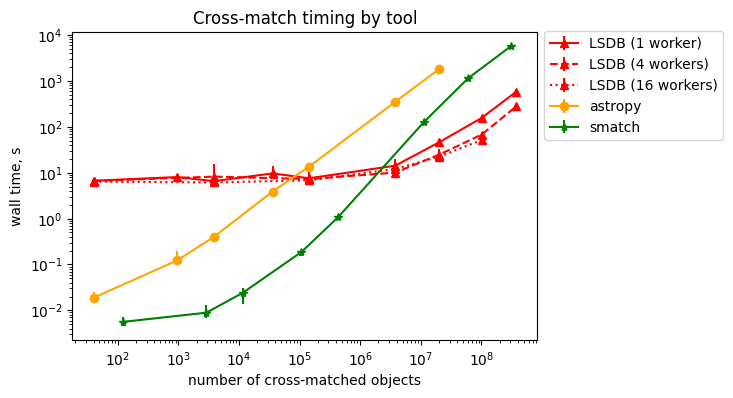

In [12]:
fig, ax = plt.subplots(    1, 1, figsize=(6, 4))


legend_dict = {}

length = None
for line_style, dask_n_workers in zip(["-", "--", ":"], dask_n_workers_):
    if length is None or DEBUG:
        length = [
            l
            for w, l in lsdb_dict.keys()
            if w == dask_n_workers
        ]
        radius_deg = np.vectorize(length_to_radius.get)(length)
    time_median = np.array(
        [
            np.nanmedian(t)
            for (w, _l), t in lsdb_dict.items()
            if w == dask_n_workers
        ]
    )
    time_q10, time_q90 = np.array(
        [
            np.nanquantile(t, [0.1, 0.9])
            for (w, _l), t in lsdb_dict.items()
            if w == dask_n_workers
        ]
    ).T

    legend_dict[
        f'LSDB ({dask_n_workers} worker{"s" if dask_n_workers > 1 else ""})'
    ] = ax.errorbar(
        length,
        time_median,
        [time_median - time_q10, time_q90 - time_median],
        ls=line_style,
        marker="^",
        color="r",
    )

length = [l for l in astropy_dict.keys()]
time_median = np.array(
    [
        np.nanmedian(t)
        for l, t in astropy_dict.items()
    ]
)
time_q10, time_q90 = np.array(
    [
        np.nanquantile(t, [0.1, 0.9])
        for l, t in astropy_dict.items()
    ]
).T
legend_dict["astropy"] = ax.errorbar(
    length,
    time_median,
    [time_median - time_q10, time_q90 - time_median],
    ls=None,
    marker="o",
    color="orange",
)

# length = [l for l in skycoord_dict.keys()]
# time_median = np.array(
#     [
#         np.nanmedian(t)
#         for l, t in skycoord_dict.items()
#     ]
# )
# time_q10, time_q90 = np.array(
#     [
#         np.nanquantile(t, [0.1, 0.9])
#         for l, t in skycoord_dict.items()
#     ]
# ).T
# legend_dict["SkyCoord init"] = ax.errorbar(
#     length,
#     time_median,
#     [time_median - time_q10, time_q90 - time_median],
#     ls=None,
#     marker="x",
#     color="b",
# )

length = [l for l in smatch_dict.keys()]
time_median = np.array(
    [
        np.nanmedian(t)
        for l, t in smatch_dict.items()
    ]
)
time_q10, time_q90 = np.array(
    [
        np.nanquantile(t, [0.1, 0.9])
        for l, t in smatch_dict.items()
    ]
).T
legend_dict["smatch"] = ax.errorbar(
    length,
    time_median,
    [time_median - time_q10, time_q90 - time_median],
    ls=None,
    marker="*",
    color="g",
)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("number of cross-matched objects")
ax.set_ylabel("wall time, s")
ax.set_title("Cross-match timing by tool")

fig.legend(
    legend_dict.values(),
    legend_dict.keys(),
    bbox_to_anchor=(0.9, 0.9),
    loc="upper left",
)